<a href="https://colab.research.google.com/github/smokingelephants/RL_test/blob/master/Custom_Maze_env_DQN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install gymnasium==0.26.3
# !pip install stable-baselines3[extra]

  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: Gymnasium 0.26.3
    Uninstalling Gymnasium-0.26.3:
      Successfully uninstalled Gymnasium-0.26.3


##  Gym env skeleton

In practice this is how a gym environment looks like.
Here, we have implemented a simple grid world were the agent must learn to go always left.

In [92]:
# import numpy as np
# import gymnasium as gym
# from gymnasium import spaces


# class GoLeftEnv(gym.Env):
#     """
#     Custom Environment that follows gym interface.
#     This is a simple env where the agent must learn to go always left.
#     """

#     # Because of google colab, we cannot implement the GUI ('human' render mode)
#     metadata = {"render_modes": ["console"]}

#     # Define constants for clearer code
#     LEFT = 0
#     RIGHT = 1

#     def __init__(self, grid_size=10, render_mode="console"):
#         super(GoLeftEnv, self).__init__()
#         self.render_mode = render_mode

#         # Size of the 1D-grid
#         self.grid_size = grid_size
#         # Initialize the agent at the right of the grid
#         self.agent_pos = grid_size - 1

#         # Define action and observation space
#         # They must be gym.spaces objects
#         # Example when using discrete actions, we have two: left and right
#         n_actions = 2
#         self.action_space = spaces.Discrete(n_actions)
#         # The observation will be the coordinate of the agent
#         # this can be described both by Discrete and Box space
#         self.observation_space = spaces.Box(
#             low=0, high=self.grid_size, shape=(1,), dtype=np.float32
#         )

#     def reset(self, seed=None, options=None):
#         """
#         Important: the observation must be a numpy array
#         :return: (np.array)
#         """
#         super().reset(seed=seed, options=options)
#         # Initialize the agent at the right of the grid
#         self.agent_pos = self.grid_size - 1
#         # here we convert to float32 to make it more general (in case we want to use continuous actions)
#         return np.array([self.agent_pos]).astype(np.float32), {}  # empty info dict

#     def step(self, action):
#         if action == self.LEFT:
#             self.agent_pos -= 1
#         elif action == self.RIGHT:
#             self.agent_pos += 1
#         else:
#             raise ValueError(
#                 f"Received invalid action={action} which is not part of the action space"
#             )

#         # Account for the boundaries of the grid
#         self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size)

#         # Are we at the left of the grid?
#         terminated = bool(self.agent_pos == 0)
#         truncated = False  # we do not limit the number of steps here

#         # Null reward everywhere except when reaching the goal (left of the grid)
#         reward = 1 if self.agent_pos == 0 else 0

#         # Optionally we can pass additional info, we are not using that for now
#         info = {}

#         return (
#             np.array([self.agent_pos]).astype(np.float32),
#             reward,
#             terminated,
#             truncated,
#             info,
#         )

#     def render(self):
#         # agent is represented as a cross, rest as a dot
#         if self.render_mode == "console":
#             print("." * self.agent_pos, end="")
#             print("x", end="")
#             print("." * (self.grid_size - self.agent_pos))

#     def close(self):
#         pass

# Maze environment

In [108]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import math
from numpy.random import random_integers as rnd
import matplotlib.pyplot as plt

class MazeEnv_new(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple env where the agent must learn to go always left.
    """

    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {"render_modes": ["None"]}

    # Define constants for clearer code
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

    #True are obstacles
    def make_maze(self, width=25, height=25, complexity=.05, density =.05): #.75 .75 #.75 .05
        # Only odd shapes
        shape = ((height//2)*2+1, (width//2)*2+1)
        # Adjust complexity and density relative to maze size
        complexity = int(complexity*(5*(shape[0]+shape[1])))
        density    = int(density*(shape[0]//2*shape[1]//2))
        # Build actual maze
        Z = np.zeros(shape, dtype=bool)
        # Fill borders
        Z[0,:] = Z[-1,:] = 1
        Z[:,0] = Z[:,-1] = 1
        # Make isles
        for i in range(density):
            x, y = rnd(0,shape[1]//2)*2, rnd(0,shape[0]//2)*2
            Z[y,x] = 1
            for j in range(complexity):
                neighbours = []
                if x > 1:           neighbours.append( (y,x-2) )
                if x < shape[1]-2:  neighbours.append( (y,x+2) )
                if y > 1:           neighbours.append( (y-2,x) )
                if y < shape[0]-2:  neighbours.append( (y+2,x) )
                if len(neighbours):
                    y_,x_ = neighbours[rnd(0,len(neighbours)-1)]
                    if Z[y_,x_] == 0:
                        Z[y_,x_] = 1
                        Z[y_+(y-y_)//2, x_+(x-x_)//2] = 1
                        x, y = x_, y_
        return Z, width, height

    def setup_maze(self, width=25, height=25):
        # get maze and the Size of the adjusted 2D-grid
        self.maze, self.width, self.height = self.make_maze(width=width, height=height)
        #self.start_loc = np.array([0,0])
        x,y = np.where(self.maze == True)
        non_term_vars = np.zeros_like(x)
        self.obstacles = np.squeeze(np.array([[x],[y],[non_term_vars]])).T
        x,y = np.where(self.maze == False)
        non_term_vars = np.zeros_like(x)
        self.valid_points = np.squeeze(np.array([[x],[y],[non_term_vars]])).T
        self.terminal_points = np.squeeze(np.array([[x],[y],[1-non_term_vars]])).T
        self.start_loc = self.valid_points[0]
        self.goal_loc = self.valid_points[-1]

    def __init__(self, width=25, height=25, render_mode="console"):
        super(MazeEnv_new, self).__init__()
        self.render_mode = render_mode

        self.setup_maze(width=width, height=height)

        # Initialize the agent at the right of the grid
        self.current_state = self.start_loc #for now

        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions, we have two: left and right
        self.n_actions = 4
        self.action_space = spaces.Discrete(self.n_actions)
        # The observation will be the coordinate of the agent
        # this can be described both by Discrete and Box space
        max_grid_size = np.max([self.width,self.height])
        #print(max_grid_size)
        self.observation_space = spaces.Box(
            low=0, high=max_grid_size, shape=(3,), dtype=np.float32
        )



    def valid(self, state):
        nx,ny = state[0], state[1]
        return( 0 <= nx < self.height and 0 <= ny < self.width and self.maze[nx][ny] == False )

    def is_goal(self):
        # game 1
        # reach a particular goal, reach last state in valid loc array, for now
        result = bool((self.current_state==self.goal_loc).all())
        r = np.random.rand()
        if r > 0.999:
          result = True
        return result


    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)
        # Initialize the agent at the right of the grid
        #self.current_state = self.start_loc
        self.current_state = self.valid_points[np.random.randint(len(self.valid_points))]
        # here we convert to float32 to make it more general (in case we want to use continuous actions)
        return np.array(self.current_state).astype(np.float32), {}  # empty info dict


    def step(self, action):
        self.next_state = np.array(self.current_state)
        self.slip = 0.1
        r = np.random.rand()
        if r < self.slip:
            action = np.random.randint(self.n_actions)
        if action == self.UP:
            self.next_state[0] = self.next_state[0] - 1
        elif action == self.DOWN:
            self.next_state[0] = self.next_state[0] + 1
        elif action == self.LEFT:
            self.next_state[1] = self.next_state[1] - 1
        elif action == self.RIGHT:
            self.next_state[1] = self.next_state[1] + 1
        else:
            raise ValueError(
                f"Received invalid action={action} which is not part of the action space"
            )

        # Account for the boundaries of the grid
        if not self.valid(self.next_state):
            self.next_state = np.array(self.current_state)
            reward = -5.0
        else:
            reward = -np.random.rand()

        # Are we at the left of the grid?
        terminated = self.is_goal()
        truncated = False  # we do not limit the number of steps here

        # Null reward everywhere except when reaching the goal (left of the grid)
        if self.is_goal():
            reward = 1000.0

        # Optionally we can pass additional info, we are not using that for now
        info = {}

        self.current_state = np.array(self.next_state)
        return (
            np.array(self.next_state).astype(np.float32),
            reward,
            terminated,
            truncated,
            info,
        )

    def render(self):
      # agent is represented as a cross, rest as a dot
        gym.logger.warn(
            "Render mode not implemented"
        )
        return

    def show_path(self, points, color = 'r', name = 'curr', stayAwake = False):
        plt.imshow(self.maze, cmap=plt.cm.binary,interpolation='nearest')
        plt.scatter(points[:,1], points[:,0], s=5, c=color)  #s=7
        #plt.savefig(name + '_maze_path.png')

        if not stayAwake:
            plt.show()
            plt.close()

    def close(self):
        pass

In [128]:
a = np.array([[]])
b = np.array(a)
a[2] = 10
print(a,b)

[ 1  2 10  4] [1 2 3 4]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Validate the environment

Stable Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that your environment follows the Gym interface. It also optionally checks that the environment is compatible with Stable-Baselines (and emits warning if necessary).

In [4]:
from stable_baselines3.common.env_checker import check_env

<ipython-input-108-0d4da59cd8ed>:37: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  x, y = rnd(0,shape[1]//2)*2, rnd(0,shape[0]//2)*2
<ipython-input-108-0d4da59cd8ed>:46: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
  y_,x_ = neighbours[rnd(0,len(neighbours)-1)]
<ipython-input-108-0d4da59cd8ed>:46: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  y_,x_ = neighbours[rnd(0,len(neighbours)-1)]


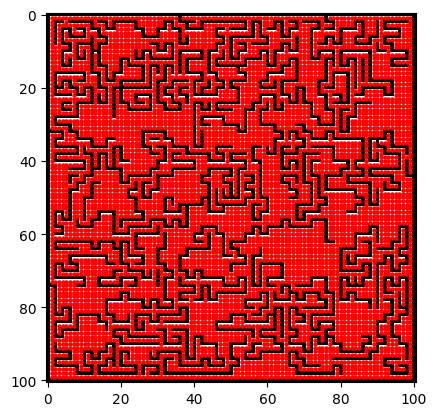

In [109]:
# env = GoLeftEnv()
env = MazeEnv_new(width=100, height=100)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)
env.show_path(env.valid_points)

### Testing the environment

<ipython-input-108-0d4da59cd8ed>:166: UserWarning: WARN: Render mode not implemented
  gym.logger.warn(


Box(0.0, 100.0, (3,), float32)
Discrete(4)
2
Step 1
Action right
obs= [ 7. 20.  0.] reward= -0.7458456672154163 done= False
Step 2
Action right
obs= [ 7. 21.  0.] reward= -0.9086645482479843 done= False
Step 3
Action up
obs= [ 6. 21.  0.] reward= -0.9639887322996373 done= False
Step 4
Action left
obs= [ 6. 20.  0.] reward= -0.1371386881162301 done= False
Step 5
Action down
obs= [ 7. 20.  0.] reward= -0.7321689570027544 done= False
Step 6
Action left
obs= [ 7. 19.  0.] reward= -0.3150488929693337 done= False
Step 7
Action up
obs= [ 6. 19.  0.] reward= -0.16096202334856635 done= False
Step 8
Action up
obs= [ 5. 19.  0.] reward= -0.8709625845172845 done= False
Step 9
Action right
obs= [ 5. 18.  0.] reward= -0.9208353612984147 done= False
Step 10
Action left
obs= [ 5. 17.  0.] reward= -0.6356013304911833 done= False
Step 11
Action up
obs= [ 5. 17.  0.] reward= -5.0 done= False
Step 12
Action left
obs= [ 5. 16.  0.] reward= -0.5032331550724596 done= False
Step 13
Action right
obs= [ 5. 17. 

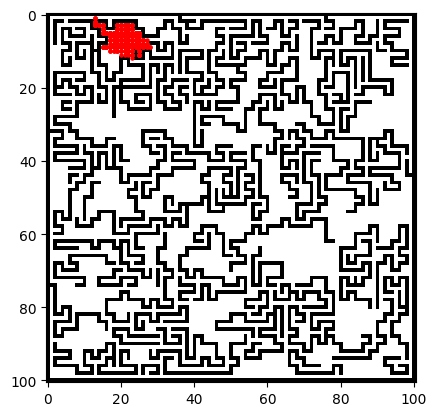

In [110]:
obs, _ = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

actions = ['up','down','left','right']
# Hardcoded best agent: always go left!
n_steps = 3000
state_history = []
state_history.append(obs)
for step in range(n_steps):
    print(f"Step {step + 1}")
    action = np.random.randint(4)
    print(f"Action {actions[action]}")
    obs, reward, terminated, truncated, info = env.step(action)
    state_history.append(obs)
    done = terminated or truncated

    print("obs=", obs, "reward=", reward, "done=", done)
    env.render()
    if done:
        print("Goal reached!", "reward=", reward)
        break

# print(np.array(state_history))
env.show_path(np.array(state_history))

### Try it with Stable-Baselines

Once your environment follow the gym interface, it is quite easy to plug in any algorithm from stable-baselines

In [119]:
from stable_baselines3 import PPO, A2C, DQN, TD3
from stable_baselines3.common.env_util import make_vec_env

# Instantiate the env
vec_env = make_vec_env(MazeEnv_new, n_envs=1, env_kwargs=dict(width=41, height=41))

<ipython-input-108-0d4da59cd8ed>:37: DeprecationWarning: This function is deprecated. Please call randint(0, 20 + 1) instead
  x, y = rnd(0,shape[1]//2)*2, rnd(0,shape[0]//2)*2
<ipython-input-108-0d4da59cd8ed>:46: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  y_,x_ = neighbours[rnd(0,len(neighbours)-1)]
<ipython-input-108-0d4da59cd8ed>:46: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
  y_,x_ = neighbours[rnd(0,len(neighbours)-1)]


In [145]:
# Train the agent
model = PPO("MlpPolicy", vec_env, verbose=1, learning_rate=0.00001)

Using cpu device


In [147]:
model = model.learn(total_timesteps=250000)

-----------------------------
| time/              |      |
|    fps             | 1187 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 416          |
| time/                   |              |
|    fps                  | 836          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0007034128 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 1.59e-05     |
|    learning_rate        | 1e-05        |
|    loss                 | 9.03e+03     |
|    n_updates            | 1240         |
|    policy_grad

KeyboardInterrupt: 

Step 1
Action right
obs= [10.  8.  0.] reward= -0.8199043067104413 done= False
Step 2
Action right
obs= [10.  9.  0.] reward= -0.5550956711480965 done= False
Step 3
Action right
obs= [10. 10.  0.] reward= -0.5694476488764697 done= False
Step 4
Action right
obs= [10.  9.  0.] reward= -0.9997200786653847 done= False
Step 5
Action right
obs= [10. 10.  0.] reward= -0.1363314460146532 done= False
Step 6
Action right
obs= [10. 11.  0.] reward= -0.2376704858096137 done= False
Step 7
Action right
obs= [10. 12.  0.] reward= -0.6400510571629023 done= False
Step 8
Action right
obs= [10. 13.  0.] reward= -0.4050570233161105 done= False
Step 9
Action right
obs= [10. 13.  0.] reward= -5.0 done= False
Step 10
Action right
obs= [10. 13.  0.] reward= -5.0 done= False
Step 11
Action right
obs= [ 9. 13.  0.] reward= -0.9542674354258024 done= False
Step 12
Action right
obs= [ 9. 12.  0.] reward= -0.7408508419994274 done= False
Step 13
Action right
obs= [ 9. 13.  0.] reward= -0.9945196382364473 done= False

<ipython-input-108-0d4da59cd8ed>:166: UserWarning: WARN: Render mode not implemented
  gym.logger.warn(


Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 45
Action right
obs= [ 9. 16.  0.] reward= -0.42740167502646487 done= False
Step 46
Action right
obs= [ 9. 17.  0.] reward= -0.9243753744576112 done= False
Step 47
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 48
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 49
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 50
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 51
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 52
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 53
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 54
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 55
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 56
Action right
obs= [ 9. 17.  0.] reward= -5.0 done= False
Step 57
Action right
obs= [ 9. 16.  0.] reward= -0.9429403730836579 done= False
Step 58
Action right
obs= [ 9. 17.  0.] reward= -0.1

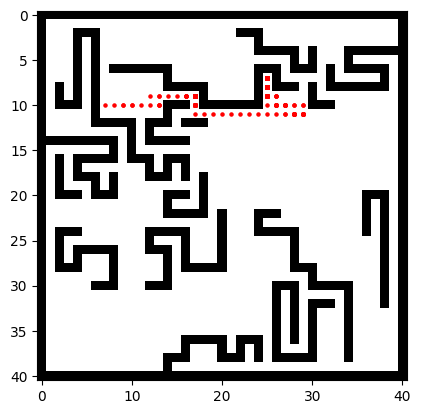

In [143]:
# Test the trained agent
# using the vecenv
# obs = vec_env.reset()
# n_steps = 2000
# for step in range(n_steps):
#     action, _ = model.predict(obs, deterministic=True)
#     print(f"Step {step + 1}")
#     print("Action: ", action)
#     obs, reward, done, info = vec_env.step(action)
#     print("obs=", obs, "reward=", reward, "done=", done)
#     vec_env.render()
#     if done:
#         # Note that the VecEnv resets automatically
#         # when a done signal is encountered
#         print("Goal reached!", "reward=", reward)
#         break


obs = vec_env.reset()[0]
actions = ['up','down','left','right']
# Hardcoded best agent: always go left!
n_steps = 5000
state_history = []
state_history.append(obs)
for step in range(n_steps):
    print(f"Step {step + 1}")
    action = model.predict(obs, deterministic=True)
    print(f"Action {actions[action[0]]}")
    obs, reward,terminated, truncated, info = vec_env.envs[0].step(action[0])
    state_history.append(obs)
    done = terminated or truncated
    print("obs=", obs, "reward=", reward, "done=", done)
    vec_env.envs[0].render()
    if done:
        print("Goal reached!", "reward=", reward)
        break

print(state_history)
vec_env.envs[0].show_path(np.array(state_history))